# Pruebas con las funciones principales del código

## Importación de librería

In [2]:
from polynomial_preprocessing import procesamiento_datos_continuos, procesamiento_datos_grillados
from polynomial_preprocessing.optimization import optimizacion_parametros_continuos, optimizacion_parametros_grillados
import numpy as np
from scipy.interpolate import griddata

In [2]:
from astropy.io import fits
fits_image_filename = '/home/stephan/polynomial_preprocessing/datasets/DoAr25/imagen_recortada.fits'

hdul = fits.open(fits_image_filename) 

# Obtener el header de la primera extensión (HDU)
header = hdul[0].header

# Buscar el atributo OBJECT en el header
if 'OBJECT' in header:
    object_name = header['OBJECT']
    print(f"El objeto en el archivo FITS es: {object_name}")
else:
    print("El atributo OBJECT no se encuentra en el header.")


El objeto en el archivo FITS es: DoAr_25


## Ejemplo de uso de optimización de parametros:

In [ ]:
ejemplo_opti_dc = optimizacion_parametros_continuos.OptimizacionParametrosContinuos(
    "/home/stephan/polynomial_preprocessing/datasets/HD142/dirty_images_natural_251.fits",
    "/home/stephan/polynomial_preprocessing/datasets/HD142/hd142_b9cont_self_tav.ms",  
	[10, 24],
	[1e-3, 1e-1],
	0.0007310213536,
	251)

ejemplo_opti_dc.initialize_optimization(100)

## Ejemplo de uso del procesamiento de datos continuos con los parametros óptimos encontrados anteriormente:

visbilidades dim. MS:  (15125, 1, 2)
visibilidades gridd. MS:  (15125,)
u_target:  (251, 251)
v_target:  (251, 251)
New S: 13
Division: 0.09783163540608564
Sigma: 7143.233010259968
El tiempo de ejecución fue de:  1.9335408210754395


/home/stephan/anaconda3/envs/pyralysis-env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stephan/anaconda3/envs/pyralysis-env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


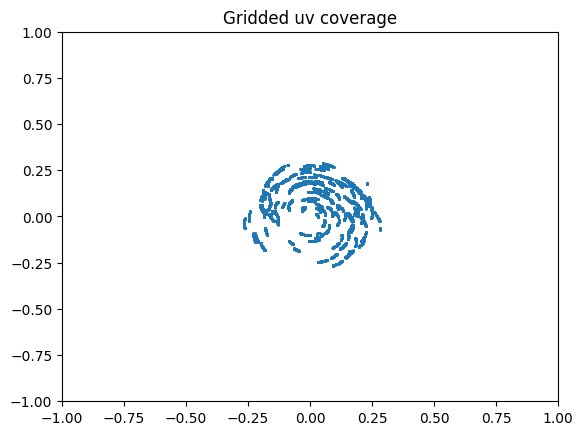

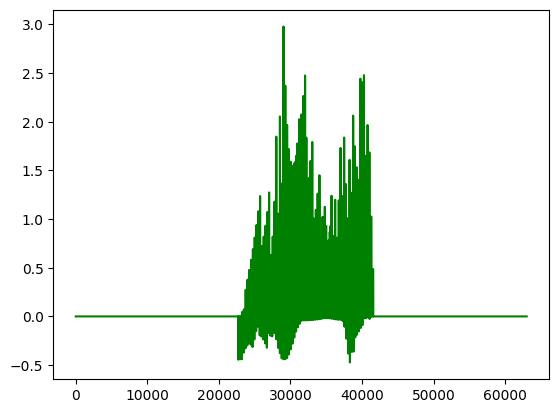

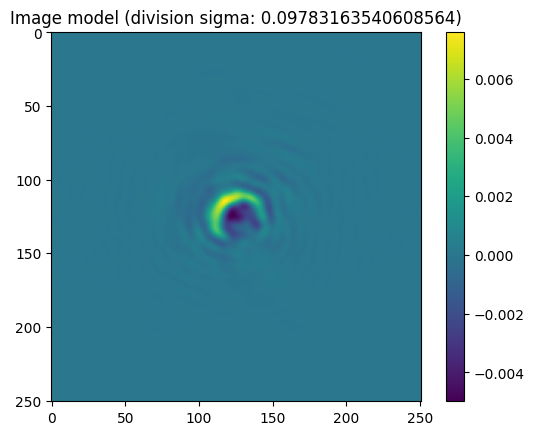

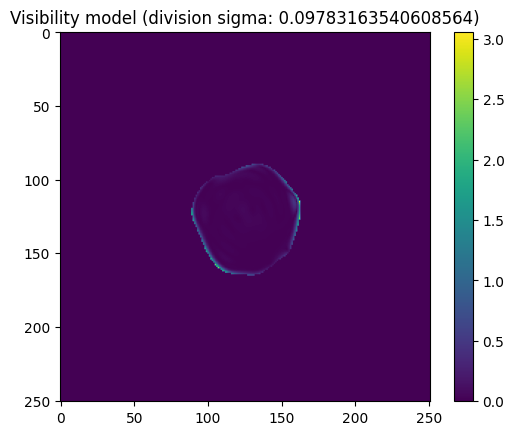

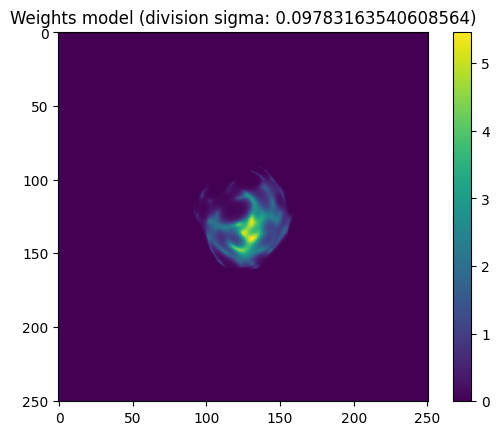

In [17]:
ejemplo_dc = procesamiento_datos_continuos.ProcesamientoDatosContinuos(
    "/home/stephan/polynomial_preprocessing/datasets/HD142/dirty_images_natural_251.fits",
    "/home/stephan/polynomial_preprocessing/datasets/HD142/hd142_b9cont_self_tav.ms", 
    13, 
    0.09783163540608564, 
    0.0007310213536, 
    251)

dirty_image_dc, pesos_dc, visibilidades_dc, u_data_dc, v_data_dc = ejemplo_dc.data_processing()

In [15]:
print("visibilities: ", visibilidades_dc.shape)

print("dirty image: ",dirty_image_dc.shape)

print("weights: ", pesos_dc.shape)

print("u coords: ", u_data_dc.shape)

print("v coords: ", v_data_dc.shape)
      

visibilities:  (251, 251)
dirty image:  (251, 251)
weights:  (251, 251)
u coords:  (15125,)
v coords:  (15125,)


In [4]:
print(pesos_dc)

[[2.84146380e-24 3.11237481e-24 3.40863488e-24 ... 8.86312470e-24
  7.96062475e-24 7.15158905e-24]
 [3.14487681e-24 3.44768363e-24 3.77912347e-24 ... 9.69367521e-24
  8.70082476e-24 7.81143528e-24]
 [3.48063962e-24 3.81910759e-24 4.18992100e-24 ... 1.06030576e-23
  9.51071829e-24 8.53291308e-24]
 ...
 [7.97608292e-24 8.91969331e-24 9.97769674e-24 ... 7.83263375e-24
  7.08675826e-24 6.41175231e-24]
 [7.33015556e-24 8.19183706e-24 9.15727323e-24 ... 7.07986538e-24
  6.41137010e-24 5.80582761e-24]
 [6.73660953e-24 7.52348197e-24 8.40445972e-24 ... 6.39919748e-24
  5.80006312e-24 5.25685037e-24]]


In [5]:
print(u_data_dc)

[  46.69929199   46.69928773  119.07919522 ...  -14.62868347 -112.27899533
  139.15162343]


In [6]:
print(v_data_dc)

[-160.47567874 -160.47567874  -30.99829882 ...   63.89080259   83.9271034
   26.81879913]


In [3]:
import numpy as np

def fletcher_reeves_conjugate_gradient(
    initial_image, visibilities, weights, u, v, max_iter=100, ftol=1e-6, gtol=1e-6, eps=1e-8, verbose=True
):
    """
    Algoritmo de gradiente conjugado no lineal utilizando el método de Fletcher-Reeves.

    Parámetros:
    -----------
    initial_image : numpy.ndarray
        Imagen inicial (2D array).
    visibilities : numpy.ndarray
        Visibilidades extrapoladas (1D array complejo).
    weights : numpy.ndarray
        Pesos de las visibilidades (1D array).
    u : numpy.ndarray
        Coordenadas u (parte real del plano uv).
    v : numpy.ndarray
        Coordenadas v (parte imaginaria del plano uv).
    max_iter : int, opcional
        Número máximo de iteraciones (por defecto 100).
    ftol : float, opcional
        Tolerancia para la diferencia en la función objetivo (por defecto 1e-6).
    gtol : float, opcional
        Tolerancia para la norma del gradiente (por defecto 1e-6).
    eps : float, opcional
        Valor pequeño para evitar divisiones por cero (por defecto 1e-8).
    verbose : bool, opcional
        Si es True, imprime información de progreso (por defecto True).

    Retorna:
    --------
    numpy.ndarray
        Imagen reconstruida.
    """
    # Inicializar la imagen
    x = initial_image.copy()

    # Calcular la función objetivo y el gradiente inicial
    f_prev = objective_function(x, visibilities, weights, u, v)
    g_prev = compute_gradient(x, visibilities, weights, u, v)

    # Inicializar la dirección de búsqueda
    d_prev = -g_prev

    for it in range(max_iter):
        if verbose:
            print(f"Iteración {it + 1}")

        # Búsqueda de línea para encontrar el tamaño de paso óptimo (alpha)
        alpha = line_search(x, d_prev, visibilities, weights, u, v)

        # Actualizar la imagen
        x = x + alpha * d_prev

        # Calcular la función objetivo y el gradiente en la nueva posición
        f_it = objective_function(x, visibilities, weights, u, v)
        g_it = compute_gradient(x, visibilities, weights, u, v)

        # Verificar criterio de parada basado en la función objetivo
        if 2.0 * abs(f_it - f_prev) <= ftol * (abs(f_it) + abs(f_prev) + eps):
            if verbose:
                print("Criterio de parada alcanzado: cambio en la función objetivo es pequeño.")
            break

        # Verificar criterio de parada basado en la norma del gradiente
        if np.linalg.norm(g_it) < gtol:
            if verbose:
                print("Criterio de parada alcanzado: norma del gradiente es pequeña.")
            break

        # Calcular el parámetro de Fletcher-Reeves (beta)
        beta = np.sum(g_it**2) / np.sum(g_prev**2)

        # Actualizar la dirección de búsqueda
        d_prev = -g_it + beta * d_prev

        # Actualizar valores para la siguiente iteración
        f_prev, g_prev = f_it, g_it

        if verbose:
            print(f"Valor de la función objetivo: {f_it:.6f}")
            print(f"Norma del gradiente: {np.linalg.norm(g_it):.6f}")

    return x


def objective_function(image, visibilities, weights, u, v):
    """
    Calcula la función objetivo (chi-cuadrado) para la imagen dada.

    Parámetros:
    -----------
    image : numpy.ndarray
        Imagen actual (2D array).
    visibilities : numpy.ndarray
        Visibilidades extrapoladas (1D array complejo).
    weights : numpy.ndarray
        Pesos de las visibilidades (1D array).
    u : numpy.ndarray
        Coordenadas u (parte real del plano uv).
    v : numpy.ndarray
        Coordenadas v (parte imaginaria del plano uv).

    Retorna:
    --------
    float
        Valor de la función objetivo.
    """
    # Calcular las visibilidades modeladas a partir de la imagen
    model_visibilities = compute_model_visibilities(image, u, v)

    # Calcular la discrepancia entre las visibilidades observadas y modeladas
    residual = visibilities - model_visibilities

    # Calcular la función objetivo (chi-cuadrado)
    chi2 = np.sum(weights * np.abs(residual)**2)
    return chi2


def compute_gradient(image, visibilities, weights, u, v):
    """
    Calcula el gradiente de la función objetivo.

    Parámetros:
    -----------
    image : numpy.ndarray
        Imagen actual (2D array).
    visibilities : numpy.ndarray
        Visibilidades extrapoladas (1D array complejo).
    weights : numpy.ndarray
        Pesos de las visibilidades (1D array).
    u : numpy.ndarray
        Coordenadas u (parte real del plano uv).
    v : numpy.ndarray
        Coordenadas v (parte imaginaria del plano uv).

    Retorna:
    --------
    numpy.ndarray
        Gradiente de la función objetivo.
    """
    # Calcular las visibilidades modeladas y su gradiente
    model_visibilities = compute_model_visibilities(image, u, v)
    grad_model_visibilities = compute_gradient_model_visibilities(image, u, v)

    # Calcular el gradiente de la función objetivo
    residual = visibilities - model_visibilities
    gradient = -2 * np.sum(weights * residual * grad_model_visibilities, axis=0)
    return gradient


def compute_model_visibilities(image, u, v):
    """
    Calcula las visibilidades modeladas a partir de la imagen.

    Parámetros:
    -----------
    image : numpy.ndarray
        Imagen actual (2D array).
    u : numpy.ndarray
        Coordenadas u (parte real del plano uv).
    v : numpy.ndarray
        Coordenadas v (parte imaginaria del plano uv).

    Retorna:
    --------
    numpy.ndarray
        Visibilidades modeladas (1D array complejo).
    """
    # Transformada de Fourier no uniforme (NUFFT) o interpolación para calcular las visibilidades
    # Aquí se usa una aproximación simple con FFT para fines ilustrativos.
    # En la práctica, debes usar una implementación de NUFFT.
    return np.fft.fft2(image)[u, v]


def compute_gradient_model_visibilities(image, u, v):
    """
    Calcula el gradiente de las visibilidades modeladas.

    Parámetros:
    -----------
    image : numpy.ndarray
        Imagen actual (2D array).
    u : numpy.ndarray
        Coordenadas u (parte real del plano uv).
    v : numpy.ndarray
        Coordenadas v (parte imaginaria del plano uv).

    Retorna:
    --------
    numpy.ndarray
        Gradiente de las visibilidades modeladas.
    """
    # Derivada de la transformada de Fourier no uniforme (NUFFT) o interpolación
    # Aquí se usa una aproximación simple con FFT para fines ilustrativos.
    # En la práctica, debes usar una implementación de NUFFT.
    return np.fft.fft2(image)[u, v]


def line_search(x, d, visibilities, weights, u, v, alpha_init=1.0, c=0.5, tau=0.5):
    """
    Búsqueda de línea para encontrar el tamaño de paso óptimo (alpha).

    Parámetros:
    -----------
    x : numpy.ndarray
        Imagen actual (2D array).
    d : numpy.ndarray
        Dirección de búsqueda (2D array).
    visibilities : numpy.ndarray
        Visibilidades extrapoladas (1D array complejo).
    weights : numpy.ndarray
        Pesos de las visibilidades (1D array).
    u : numpy.ndarray
        Coordenadas u (parte real del plano uv).
    v : numpy.ndarray
        Coordenadas v (parte imaginaria del plano uv).
    alpha_init : float, opcional
        Valor inicial de alpha (por defecto 1.0).
    c : float, opcional
        Factor de reducción de alpha (por defecto 0.5).
    tau : float, opcional
        Factor de decrecimiento (por defecto 0.5).

    Retorna:
    --------
    float
        Tamaño de paso óptimo (alpha).
    """
    alpha = alpha_init
    f_x = objective_function(x, visibilities, weights, u, v)
    g_x = compute_gradient(x, visibilities, weights, u, v)

    while True:
        x_new = x + alpha * d
        f_x_new = objective_function(x_new, visibilities, weights, u, v)

        # Condición de Armijo
        if f_x_new <= f_x + c * alpha * np.sum(g_x * d):
            break
        alpha *= tau

    return alpha

In [4]:
initial_image = dirty_image_dc  # Imagen inicial
visibilities = visibilidades_dc  # Visibilidades simuladas
weights = pesos_dc  # Pesos uniformes
u = u_data_dc  # Coordenadas u
v = v_data_dc  # Coordenadas v

# Ejecutar el algoritmo
reconstructed_image = fletcher_reeves_conjugate_gradient(
    initial_image, visibilities, weights, u, v, max_iter=251, verbose=True
)

# Visualizar la imagen reconstruida
import matplotlib.pyplot as plt
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.title('Imagen Reconstruida')
plt.colorbar()
plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
# Ejemplo de uso
initial_image = np.zeros((256, 256))  # Imagen inicial
visibilities = visibilidades_extrapoladas_dc  # Visibilidades simuladas
weights = pesos_dc  # Pesos uniformes
u = u_data_dc   # Coordenadas u
v = v_data_dc  # Coordenadas v

# Ejecutar el algoritmo
reconstructed_image = fletcher_reeves_conjugate_gradient(
    initial_image, visibilities, weights, u, v, max_iter=100, verbose=True
)

# Visualizar la imagen reconstruida
import matplotlib.pyplot as plt
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.title('Imagen Reconstruida')
plt.colorbar()
plt.show()

Norma del gradiente inicial: 0.006699979883835009


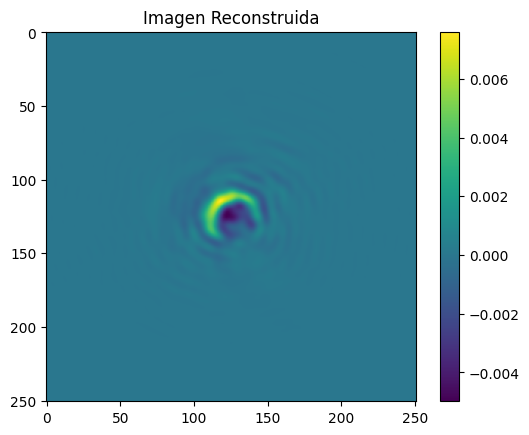

In [28]:
import numpy as np

def compute_gradient(image, visibilities, weights, u_coords, v_coords):
    """Calcula el gradiente de la función objetivo con respecto a la imagen."""
    F_image = np.fft.fft2(image)
    residual = visibilities - F_image
    gradient = np.fft.ifft2(weights * residual).real
    return gradient

def compute_fletcher_reeves_beta(grad, grad_prev):
    """Calcula el parámetro beta de Fletcher-Reeves para la actualización del gradiente conjugado."""
    numerator = np.sum(grad ** 2)
    denominator = np.sum(grad_prev ** 2)
    return numerator / denominator if denominator != 0 else 0

def line_search(image, direction, visibilities, weights, u_coords, v_coords, alpha_init=1.5, tol=1e-5):
    """Realiza la búsqueda de línea para encontrar el mejor paso en la dirección del gradiente conjugado."""
    alpha = alpha_init
    while alpha > tol:
        new_image = image + alpha * direction
        F_image = np.fft.fft2(new_image)
        loss = np.sum(weights * np.abs(visibilities - F_image) ** 2)
        if loss < np.sum(weights * np.abs(visibilities - np.fft.fft2(image)) ** 2):
            return alpha
        alpha *= 0.5  # Reduce el paso si la función no disminuye
    return alpha

def conjugate_gradient_reconstruction(image, visibilities, weights, u_coords, v_coords, max_iter=251, tol=1e-1):
    """Aplica el método de gradiente conjugado con Fletcher-Reeves para la reconstrucción de la imagen."""
    grad = compute_gradient(image, visibilities, weights, u_coords, v_coords)
    print("Norma del gradiente inicial:", np.linalg.norm(grad))

    direction = -grad
    for _ in range(max_iter):
        alpha = line_search(image, direction, visibilities, weights, u_coords, v_coords)
        new_image = image + alpha * direction
        
        if np.linalg.norm(new_image - image) < tol:
            break
        
        new_grad = compute_gradient(new_image, visibilities, weights, u_coords, v_coords)
        beta = compute_fletcher_reeves_beta(new_grad, grad)
        direction = -new_grad + beta * direction
        
        image = new_image
        grad = new_grad
        
    return image

# Parámetros de entrada simulados
image_dirty = dirty_image_dc # Imagen inicial sucia
visibilities = visibilidades_dc  # Visibilidades extrapoladas
weights = pesos_dc # Pesos uniformes
u_coords = u_data_dc  # Coordenadas u
v_coords = v_data_dc  # Coordenadas v

# Reconstrucción de la imagen
image_reconstructed = conjugate_gradient_reconstruction(image_dirty, visibilities, weights, u_coords, v_coords)

# Visualización de la imagen reconstruida (opcional)
import matplotlib.pyplot as plt
plt.imshow(image_reconstructed, cmap='viridis')
plt.title("Imagen Reconstruida")
plt.colorbar()
plt.show()


In [13]:
import numpy as np
import time

def objective_function(image, visibilities, weights, u, v):
    """
    Calcula el valor de la función objetivo.
    
    Parameters:
    -----------
    image : np.ndarray
        La imagen actual.
    visibilities : np.ndarray
        Las visibilidades extrapoladas.
    weights : np.ndarray
        Los pesos de las visibilidades.
    u : np.ndarray
        Coordenadas u (parte real).
    v : np.ndarray
        Coordenadas v (parte imaginaria).
    
    Returns:
    --------
    float
        El valor de la función objetivo.
    """
    # Simular las visibilidades a partir de la imagen actual
    simulated_visibilities = simulate_visibilities(image, u, v)
    
    # Calcular la diferencia entre las visibilidades observadas y simuladas
    diff = visibilities - simulated_visibilities
    
    # Calcular la función objetivo (chi-cuadrado)
    chi_squared = np.sum(weights * np.abs(diff)**2)
    
    return chi_squared

def gradient(image, visibilities, weights, u, v):
    """
    Calcula el gradiente de la función objetivo.
    
    Parameters:
    -----------
    image : np.ndarray
        La imagen actual.
    visibilities : np.ndarray
        Las visibilidades extrapoladas.
    weights : np.ndarray
        Los pesos de las visibilidades.
    u : np.ndarray
        Coordenadas u (parte real).
    v : np.ndarray
        Coordenadas v (parte imaginaria).
    
    Returns:
    --------
    np.ndarray
        El gradiente de la función objetivo.
    """
    # Simular las visibilidades a partir de la imagen actual
    simulated_visibilities = simulate_visibilities(image, u, v)
    
    # Calcular la diferencia entre las visibilidades observadas y simuladas
    diff = visibilities - simulated_visibilities
    
    # Calcular el gradiente
    grad = -2 * np.sum(weights * np.conj(diff) * simulate_visibilities_gradient(image, u, v), axis=0)
    
    return grad

def line_search(image, direction, visibilities, weights, u, v, max_iter=100, alpha=1.0, beta=0.5):
    """
    Realiza la búsqueda de línea para encontrar el tamaño de paso óptimo.
    
    Parameters:
    -----------
    image : np.ndarray
        La imagen actual.
    direction : np.ndarray
        La dirección de búsqueda.
    visibilities : np.ndarray
        Las visibilidades extrapoladas.
    weights : np.ndarray
        Los pesos de las visibilidades.
    u : np.ndarray
        Coordenadas u (parte real).
    v : np.ndarray
        Coordenadas v (parte imaginaria).
    max_iter : int, optional
        Número máximo de iteraciones para la búsqueda de línea.
    alpha : float, optional
        Tamaño de paso inicial.
    beta : float, optional
        Factor de reducción del tamaño de paso.
    
    Returns:
    --------
    float
        El tamaño de paso óptimo.
    """
    for i in range(max_iter):
        new_image = image + alpha * direction
        f_new = objective_function(new_image, visibilities, weights, u, v)
        f_old = objective_function(image, visibilities, weights, u, v)
        
        if f_new < f_old:
            print(f"Line search: alpha = {alpha}")  # Imprimir el valor de alpha
            return alpha
        
        alpha *= beta
    
    return alpha

def fletcher_reeves(grad, grad_prev, direction_prev):
    """
    Calcula el parámetro de Fletcher-Reeves para actualizar la dirección de búsqueda.
    
    Parameters:
    -----------
    grad : np.ndarray
        El gradiente actual.
    grad_prev : np.ndarray
        El gradiente anterior.
    direction_prev : np.ndarray
        La dirección de búsqueda anterior.
    
    Returns:
    --------
    float
        El parámetro de Fletcher-Reeves.
    """
    norm2_grad = np.sum(np.abs(grad)**2)
    norm2_grad_prev = np.sum(np.abs(grad_prev)**2)
    
    if norm2_grad_prev == 0.0:
        return 0.0
    
    return norm2_grad / norm2_grad_prev


def conjugate_gradient(image, visibilities, weights, u, v, max_iter=100, ftol=1e-6, gtol=1e-6, verbose=True):
    """
    Implementa el algoritmo de Gradiente Conjugado No Lineal utilizando el método de Fletcher-Reeves.
    
    Parameters:
    -----------
    image : np.ndarray
        La imagen inicial.
    visibilities : np.ndarray
        Las visibilidades extrapoladas.
    weights : np.ndarray
        Los pesos de las visibilidades.
    u : np.ndarray
        Coordenadas u (parte real).
    v : np.ndarray
        Coordenadas v (parte imaginaria).
    max_iter : int, optional
        Número máximo de iteraciones.
    ftol : float, optional
        Tolerancia para la función objetivo.
    gtol : float, optional
        Tolerancia para el gradiente.
    verbose : bool, optional
        Si es True, imprime información de la ejecución.
    
    Returns:
    --------
    np.ndarray
        La imagen reconstruida.
    """
    x = image.copy()
    
    # Calcular la función objetivo y el gradiente inicial
    f_prev = objective_function(x, visibilities, weights, u, v)
    g_prev = gradient(x, visibilities, weights, u, v)
    d_prev = -g_prev  # Dirección inicial de búsqueda
    
    for it in range(max_iter):
        if verbose:
            print(f"Iteration {it+1}")
            print(f"Function value = {f_prev:.04f}")  # Imprimir el valor de la función objetivo
            print(f"Gradient norm = {np.linalg.norm(g_prev):.04f}")  # Imprimir la norma del gradiente
        
        # Búsqueda de línea
        alpha = line_search(x, d_prev, visibilities, weights, u, v)
        
        # Actualizar la imagen
        x = x + alpha * d_prev
        
        # Calcular la función objetivo y el gradiente en la nueva posición
        f_it = objective_function(x, visibilities, weights, u, v)
        g_it = gradient(x, visibilities, weights, u, v)
        
        # Verificar criterios de parada
        if 2.0 * abs(f_it - f_prev) <= ftol * (abs(f_it) + abs(f_prev)):
            if verbose:
                print("Exit due to tolerance")
            return x
        
        if np.max(np.abs(g_it)) <= gtol:
            if verbose:
                print("Exit due to gradient tolerance")
            return x
        
        # Calcular el parámetro de Fletcher-Reeves
        beta = fletcher_reeves(g_it, g_prev, d_prev)
        
        # Actualizar la dirección de búsqueda
        d_it = -g_it + beta * d_prev
        
        # Actualizar valores para la siguiente iteración
        f_prev, g_prev, d_prev = f_it, g_it, d_it
    
    if verbose:
        print("Too many iterations in optimizer")
    
    return x

# Funciones auxiliares (simulación de visibilidades y gradiente)


def simulate_visibilities(image, u, v):
    """
    Simula las visibilidades a partir de la imagen y las coordenadas u, v.
    
    Parameters:
    -----------
    image : np.ndarray
        La imagen (2D array).
    u : np.ndarray
        Coordenadas u (parte real).
    v : np.ndarray
        Coordenadas v (parte imaginaria).
    
    Returns:
    --------
    np.ndarray
        Las visibilidades simuladas.
    """
    # Obtener las dimensiones de la imagen
    nx, ny = image.shape
    
    # Crear una cuadrícula de frecuencias en el espacio de Fourier
    u_grid = np.fft.fftfreq(nx).reshape(-1, 1) * nx
    v_grid = np.fft.fftfreq(ny).reshape(-1, 1) * ny
    
    # Calcular la transformada de Fourier de la imagen
    image_fft = np.fft.fft2(image)
    
    # Crear una cuadrícula de puntos (u, v) para la interpolación
    points = np.array(np.meshgrid(u_grid, v_grid)).T.reshape(-1, 2)
    
    # Interpolar la transformada de Fourier en las coordenadas (u, v)
    visibilities = griddata(points, image_fft.flatten(), (u, v), method='cubic')
    
    return visibilities

def simulate_visibilities_gradient(image, u, v):
    """
    Simula el gradiente de las visibilidades con respecto a la imagen.
    
    Parameters:
    -----------
    image : np.ndarray
        La imagen (2D array).
    u : np.ndarray
        Coordenadas u (parte real).
    v : np.ndarray
        Coordenadas v (parte imaginaria).
    
    Returns:
    --------
    np.ndarray
        El gradiente de las visibilidades simuladas.
    """
    # Obtener las dimensiones de la imagen
    nx, ny = image.shape
    
    # Crear una cuadrícula de frecuencias en el espacio de Fourier
    u_grid = np.fft.fftfreq(nx).reshape(-1, 1) * nx
    v_grid = np.fft.fftfreq(ny).reshape(-1, 1) * ny
    
    # Calcular la transformada de Fourier de la imagen
    image_fft = np.fft.fft2(image)
    
    # Calcular el gradiente de la transformada de Fourier
    # El gradiente es la transformada de Fourier multiplicada por un factor de fase
    phase_factor = -2j * np.pi * (u_grid * u + v_grid * v)
    gradient_fft = image_fft * phase_factor
    
    # Crear una cuadrícula de puntos (u, v) para la interpolación
    points = np.array(np.meshgrid(u_grid, v_grid)).T.reshape(-1, 2)
    
    # Interpolar el gradiente en las coordenadas (u, v)
    gradient = griddata(points, gradient_fft.flatten(), (u, v), method='cubic')
    
    return gradient

In [14]:
# Ejemplo de uso
image = dirty_image_dc  # Imagen inicial (aleatoria)
visibilities = visibilidades_dc  # Visibilidades extrapoladas
weights = pesos_dc  # Pesos de las visibilidades
u = u_data_dc  # Coordenadas u
v = v_data_dc  # Coordenadas v


# Reconstruir la imagen
reconstructed_image = conjugate_gradient(image, visibilities, weights, u, v, max_iter=251, ftol=1e-3, verbose=True)

Iteration 1
Function value = 479.4436
Gradient norm = 139.3262
Line search: alpha = 2.117582368135751e-22
Exit due to tolerance


Exit due to function tolerance at iteration 5


/tmp/ipykernel_45801/1812119616.py:57: RuntimeWarning: overflow encountered in square
  f_new = np.sum(weights * np.abs(vis_observed - compute_visibilities(image_new, u, v))**2)


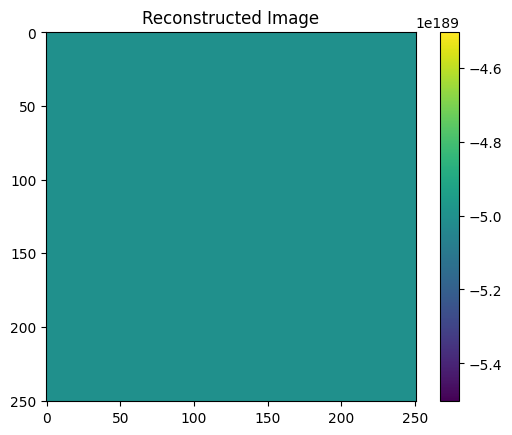

In [25]:
import numpy as np

def compute_visibilities(image, u, v):
    """
    Calcula las visibilidades a partir de una imagen y coordenadas (u, v).
    Utiliza la Transformada de Fourier No Uniforme (NUFFT).
    """
    # Obtener dimensiones de la imagen
    nx, ny = image.shape
    x = np.fft.fftfreq(nx)[:, np.newaxis]  # Frecuencias en x
    y = np.fft.fftfreq(ny)[np.newaxis, :]  # Frecuencias en y

    # Calcular la Transformada de Fourier No Uniforme (NUFFT)
    visibilities = np.sum(image * np.exp(-2j * np.pi * (u * x + v * y)), axis=(0, 1))
    return visibilities


def compute_gradient(image, u, v, vis_observed, weights):
    """
    Calcula el gradiente de la función objetivo con respecto a la imagen.
    """
    # Obtener dimensiones de la imagen
    nx, ny = image.shape
    x = np.fft.fftfreq(nx)[:, np.newaxis]  # Frecuencias en x
    y = np.fft.fftfreq(ny)[np.newaxis, :]  # Frecuencias en y

    # Calcular las visibilidades actuales
    vis_current = compute_visibilities(image, u, v)

    # Calcular el residuo (diferencia entre visibilidades observadas y calculadas)
    residual = vis_current - vis_observed

    # Calcular el gradiente utilizando la Transformada Inversa de Fourier No Uniforme (INUFFT)
    gradient = np.sum(weights * residual * np.exp(2j * np.pi * (u * x + v * y)), axis=(0, 1))
    return gradient.real  # Tomar la parte real para obtener una imagen real


def conjugate_gradient_nonlinear(image, u, v, vis_observed, weights, max_iter=100, ftol=1e-6, gtol=1e-6):
    """
    Algoritmo de Gradiente Conjugado No Lineal para reconstruir una imagen a partir de visibilidades.
    """
    # Calcular el gradiente inicial
    gradient = compute_gradient(image, u, v, vis_observed, weights)
    direction = -gradient  # Dirección inicial de búsqueda

    # Almacenar el valor de la función objetivo anterior
    f_prev = np.sum(weights * np.abs(vis_observed - compute_visibilities(image, u, v))**2)

    for it in range(max_iter):
        # Búsqueda de línea (en este caso, un paso fijo para simplificar)
        alpha = 0.001  # Tamaño del paso (puede optimizarse con una búsqueda de línea)

        # Actualizar la imagen
        image_new = image + alpha * direction

        # Calcular el valor de la función objetivo
        f_new = np.sum(weights * np.abs(vis_observed - compute_visibilities(image_new, u, v))**2)

        # Verificar criterio de parada basado en la función
        if 2.0 * abs(f_new - f_prev) <= ftol * (abs(f_new) + abs(f_prev) + 1e-10):
            print(f"Exit due to function tolerance at iteration {it}")
            return image_new

        # Calcular el nuevo gradiente
        gradient_new = compute_gradient(image_new, u, v, vis_observed, weights)

        # Verificar criterio de parada basado en el gradiente
        if np.max(np.abs(gradient_new)) <= gtol:
            print(f"Exit due to gradient tolerance at iteration {it}")
            return image_new

        # Calcular el parámetro de gradiente conjugado (Fletcher-Reeves)
        beta = np.sum(gradient_new**2) / np.sum(gradient**2)

        # Actualizar la dirección de búsqueda
        direction = -gradient_new + beta * direction

        # Actualizar valores para la siguiente iteración
        image, gradient, f_prev = image_new, gradient_new, f_new

    print("Too many iterations in optimizer")
    return image




# Datos de entrada (simulados)
image = dirty_image_dc
u = u_data_dc  # Coordenadas u
v = v_data_dc  # Coordenadas v
weights = pesos_dc  # Pesos de las visibilidades
vis_observed = visibilidades_dc  # Visibilidades observadas


# Reconstruir la imagen
reconstructed_image = conjugate_gradient_nonlinear(image, u, v, vis_observed, weights)

# Visualizar la imagen reconstruida (requiere matplotlib)
import matplotlib.pyplot as plt
plt.imshow(reconstructed_image, cmap='viridis')
plt.colorbar()
plt.title("Reconstructed Image")
plt.show()

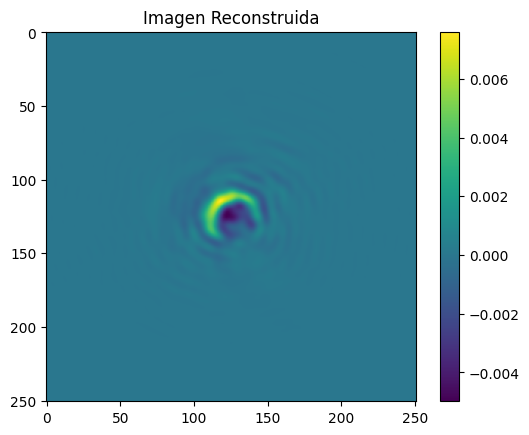

In [11]:
# Visualización de la imagen reconstruida (opcional)
import matplotlib.pyplot as plt
plt.imshow(np.real(reconstructed_image), cmap='viridis')
plt.title("Imagen Reconstruida")
plt.colorbar()
plt.show()

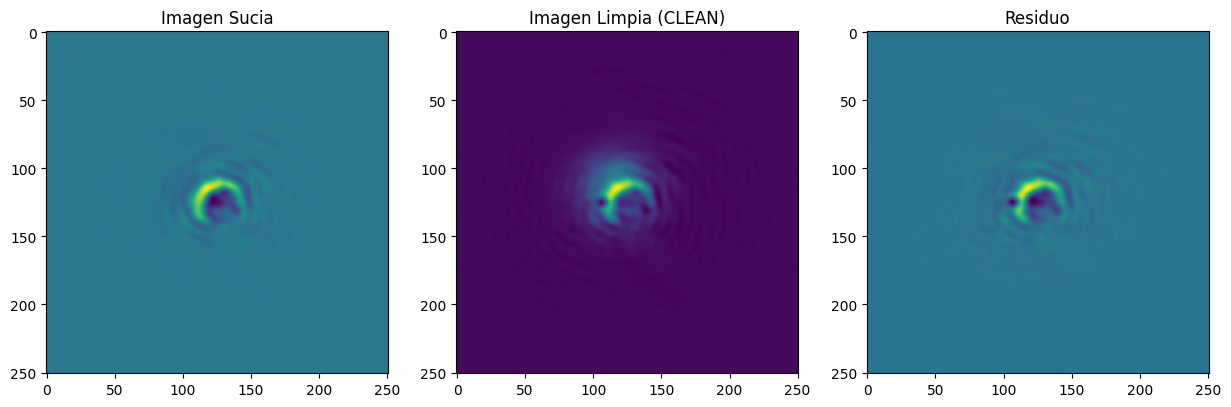

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

def generate_gaussian_beam(size, fwhm):
    """
    Genera un haz Gaussiano (PSF) para la restauración.
    :param size: Tamaño del haz (tamaño de la imagen).
    :param fwhm: Ancho a mitad del máximo (FWHM) del haz.
    :return: Haz Gaussiano.
    """
    x, y = np.meshgrid(np.arange(size) - size // 2, np.arange(size) - size // 2)
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Convertir FWHM a sigma
    beam = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return beam / np.max(beam)  # Normalizar

def clean_algorithm(visibilities, weights, image_size, loop_gain=0.1, max_iter=1000, threshold=0.01, fwhm=3):
    """
    Implementación del algoritmo CLEAN.
    :param visibilities: Visibilidades (datos en el espacio de Fourier).
    :param weights: Pesos de las visibilidades.
    :param image_size: Tamaño de la imagen de salida.
    :param loop_gain: Ganancia del bucle (fracción del pico a restar en cada iteración).
    :param max_iter: Número máximo de iteraciones.
    :param threshold: Umbral de residuo para detener el algoritmo.
    :param fwhm: Ancho a mitad del máximo (FWHM) del haz de restauración.
    :return: Imagen limpia, residuo, componentes CLEAN.
    """
    # Paso 1: Calcular la imagen sucia (transformada inversa de Fourier)
    dirty_image = np.fft.ifft2(np.fft.ifftshift(visibilities * weights)).real
    dirty_image = np.fft.fftshift(dirty_image)  # Aplicar fftshift para corregir el orden
    dirty_image = dirty_image / np.max(dirty_image)  # Normalizar

    # Paso 2: Calcular el PSF (haz sintético)
    psf = np.fft.ifft2(np.fft.ifftshift(weights)).real
    psf = np.fft.fftshift(psf)  # Aplicar fftshift para corregir el orden
    psf = psf / np.max(psf)  # Normalizar

    # Inicializar variables
    clean_components = np.zeros_like(dirty_image)  # Componentes CLEAN
    residual = dirty_image.copy()  # Residuo inicial
    beam = generate_gaussian_beam(image_size, fwhm)  # Haz de restauración

    # Iteraciones CLEAN
    for i in range(max_iter):
        # Encontrar el pico más brillante en el residuo
        max_pos = np.unravel_index(np.argmax(np.abs(residual)), residual.shape)
        max_value = residual[max_pos]

        # Verificar el criterio de parada
        if np.abs(max_value) < threshold:
            print(f"Criterio de parada alcanzado en la iteración {i}.")
            break

        # Agregar el componente CLEAN
        clean_components[max_pos] += loop_gain * max_value

        # Restar el componente CLEAN del residuo
        residual -= loop_gain * max_value * np.roll(psf, (max_pos[0] - image_size // 2, max_pos[1] - image_size // 2))

    # Paso 3: Restaurar la imagen limpia
    clean_image = fftconvolve(clean_components, beam, mode="same")  # Usar fftconvolve de SciPy
    clean_image_convolved = fftconvolve(clean_components, beam, mode="same")
    final_image = clean_image_convolved + residual


    return final_image, residual, clean_components

# Parámetros
image_size = 251
fwhm = 40  # Ancho del haz de restauración
loop_gain = 0.00001  # Ganancia del bucle
max_iter = 100000 # Máximo de iteraciones
threshold = 0.2  # Umbral de residuo


# Generar datos de ejemplo (visibilidades y pesos)

visibilities = visibilidades_dc
weights = pesos_dc 

# Aplicar CLEAN
clean_image, residual, components = clean_algorithm(visibilities, weights, image_size, loop_gain, max_iter, threshold, fwhm)

# Visualizar resultados
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Imagen Sucia")
plt.imshow(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(visibilities * weights))).real, cmap="viridis")

plt.subplot(1, 3, 2)
plt.title("Imagen Limpia (CLEAN)")
plt.imshow(clean_image, cmap="viridis")

plt.subplot(1, 3, 3)
plt.title("Residuo")
plt.imshow(residual, cmap="viridis")

plt.show()



###### fits_image = fits.open("/home/stephan/polynomial_preprocessing/datasets/HD142/dirty_images_natural_251.fits")
header = fits_image[0].header
fits.writeto("/home/stephan/polynomial_preprocessing/datasets/HD142/dirty_images_natural_251_TESTING_2.fits", image_reconstructed, header,overwrite=True)

In [2]:
ejemplo_opti_dc_1 = optimizacion_parametros_continuos.OptimizacionParametrosContinuos(
    "/home/stephan/polynomial_preprocessing/datasets/pyralysis-development-datasets/FREQ78/mod_in_0.fits",
    "/home/stephan/polynomial_preprocessing/datasets/pyralysis-development-datasets/FREQ78/FREQ78.ms",   
	[5, 16],
	[1e-4, 1e-1],
	-1.38 * (10 ** (-7/2)),
	None)

ejemplo_opti_dc_1.initialize_optimization(50)

[I 2025-02-21 00:47:48,998] A new study created in memory with name: no-name-56e26105-d3e5-43f4-9793-33d0c69d8bc2


Image size of FITS:  512
New S: 13
Division: 0.041107593021724016
Sigma: 10390.226880758031


[I 2025-02-21 00:47:56,955] Trial 0 finished with value: 105.12127685546875 and parameters: {'S': 13, 'division': 0.041107593021724016}. Best is trial 0 with value: 105.12127685546875.


El tiempo de ejecución fue de:  7.115442752838135
New S: 6
Division: 0.09960181218948495
Sigma: 4288.24745884161


[I 2025-02-21 00:47:57,810] Trial 1 finished with value: 98.89764404296875 and parameters: {'S': 6, 'division': 0.09960181218948495}. Best is trial 1 with value: 98.89764404296875.


El tiempo de ejecución fue de:  0.5547776222229004
New S: 11
Division: 0.00965391785450602
Sigma: 44242.88920360129


[I 2025-02-21 00:48:01,678] Trial 2 finished with value: 102.19354248046875 and parameters: {'S': 11, 'division': 0.00965391785450602}. Best is trial 1 with value: 98.89764404296875.


El tiempo de ejecución fue de:  3.567152738571167
New S: 12
Division: 0.0718657483138392
Sigma: 5943.265436440576


[I 2025-02-21 00:48:06,732] Trial 3 finished with value: 106.38983154296875 and parameters: {'S': 12, 'division': 0.0718657483138392}. Best is trial 1 with value: 98.89764404296875.


El tiempo de ejecución fue de:  4.74030613899231
New S: 6
Division: 0.033521215413908186
Sigma: 12741.698436160052


[I 2025-02-21 00:48:07,638] Trial 4 finished with value: 98.42840576171875 and parameters: {'S': 6, 'division': 0.033521215413908186}. Best is trial 4 with value: 98.42840576171875.


El tiempo de ejecución fue de:  0.5876986980438232
New S: 13
Division: 0.05748161158359659
Sigma: 7430.501794411479


[I 2025-02-21 00:48:14,922] Trial 5 finished with value: 105.11541748046875 and parameters: {'S': 13, 'division': 0.05748161158359659}. Best is trial 4 with value: 98.42840576171875.


El tiempo de ejecución fue de:  6.962236166000366
New S: 6
Division: 0.05500722790255988
Sigma: 7764.747185118582


[I 2025-02-21 00:48:15,778] Trial 6 finished with value: 98.27655029296875 and parameters: {'S': 6, 'division': 0.05500722790255988}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.564598798751831
New S: 7
Division: 0.09056663134468078
Sigma: 4716.05503788746


[I 2025-02-21 00:48:16,970] Trial 7 finished with value: 99.90985107421875 and parameters: {'S': 7, 'division': 0.09056663134468078}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.8888046741485596
New S: 6
Division: 0.07558570986192228
Sigma: 5650.766775860451


[I 2025-02-21 00:48:17,827] Trial 8 finished with value: 98.33026123046875 and parameters: {'S': 6, 'division': 0.07558570986192228}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.5630936622619629
New S: 9
Division: 0.05941904669345536
Sigma: 7188.220642803118


[I 2025-02-21 00:48:19,995] Trial 9 finished with value: 101.25701904296875 and parameters: {'S': 9, 'division': 0.05941904669345536}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  1.8707475662231445
New S: 16
Division: 0.02143199104300455
Sigma: 19928.956537940983


[I 2025-02-21 00:48:32,179] Trial 10 finished with value: 106.47869873046875 and parameters: {'S': 16, 'division': 0.02143199104300455}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  11.86621642112732
New S: 8
Division: 0.07673540483374625
Sigma: 5566.103664181661


[I 2025-02-21 00:48:33,801] Trial 11 finished with value: 107.32684326171875 and parameters: {'S': 8, 'division': 0.07673540483374625}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  1.2738356590270996
New S: 5
Division: 0.07486388524110141
Sigma: 5705.250490834589


[I 2025-02-21 00:48:34,466] Trial 12 finished with value: 100.94354248046875 and parameters: {'S': 5, 'division': 0.07486388524110141}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.37674498558044434
New S: 9
Division: 0.05482459131963872
Sigma: 7790.613805534752


[I 2025-02-21 00:48:36,600] Trial 13 finished with value: 101.36785888671875 and parameters: {'S': 9, 'division': 0.05482459131963872}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  1.8297505378723145
New S: 5
Division: 0.04034629835286356
Sigma: 10586.280165829976


[I 2025-02-21 00:48:37,246] Trial 14 finished with value: 103.65301513671875 and parameters: {'S': 5, 'division': 0.04034629835286356}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.33730363845825195
New S: 8
Division: 0.06787235472640393
Sigma: 6292.948281215585


[I 2025-02-21 00:48:38,761] Trial 15 finished with value: 107.35760498046875 and parameters: {'S': 8, 'division': 0.06787235472640393}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  1.2270336151123047
New S: 10
Division: 0.08351351929629686
Sigma: 5114.348211122715


[I 2025-02-21 00:48:41,580] Trial 16 finished with value: 103.45379638671875 and parameters: {'S': 10, 'division': 0.08351351929629686}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  2.5082385540008545
New S: 7
Division: 0.04747128665787448
Sigma: 8997.380271063887


[I 2025-02-21 00:48:42,754] Trial 17 finished with value: 99.63690185546875 and parameters: {'S': 7, 'division': 0.04747128665787448}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.8704438209533691
New S: 16
Division: 0.027923943568697825
Sigma: 15295.734177616941


[I 2025-02-21 00:49:02,539] Trial 18 finished with value: 106.46795654296875 and parameters: {'S': 16, 'division': 0.027923943568697825}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  19.453094720840454
New S: 5
Division: 0.06412246551924874
Sigma: 6660.960625248619


[I 2025-02-21 00:49:03,282] Trial 19 finished with value: 102.46160888671875 and parameters: {'S': 5, 'division': 0.06412246551924874}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.43703675270080566
New S: 7
Division: 0.0873619768407018
Sigma: 4889.051661415529


[I 2025-02-21 00:49:04,808] Trial 20 finished with value: 99.96307373046875 and parameters: {'S': 7, 'division': 0.0873619768407018}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  1.189424991607666
New S: 6
Division: 0.028711820448670315
Sigma: 14876.00616551496


[I 2025-02-21 00:49:05,851] Trial 21 finished with value: 98.69256591796875 and parameters: {'S': 6, 'division': 0.028711820448670315}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.7205650806427002
New S: 6
Division: 0.04574444293632432
Sigma: 9337.029606243535


[I 2025-02-21 00:49:06,886] Trial 22 finished with value: 98.27947998046875 and parameters: {'S': 6, 'division': 0.04574444293632432}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.7018246650695801
New S: 9
Division: 0.04413124894304046
Sigma: 9678.339685533303


[I 2025-02-21 00:49:09,115] Trial 23 finished with value: 101.51776123046875 and parameters: {'S': 9, 'division': 0.04413124894304046}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  1.9226596355438232
New S: 8
Division: 0.05383881635910889
Sigma: 7933.257952193351


[I 2025-02-21 00:49:10,718] Trial 24 finished with value: 107.42889404296875 and parameters: {'S': 8, 'division': 0.05383881635910889}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  1.2792069911956787
New S: 6
Division: 0.013353947549236994
Sigma: 31984.341442316236


[I 2025-02-21 00:49:11,539] Trial 25 finished with value: 99.44940185546875 and parameters: {'S': 6, 'division': 0.013353947549236994}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.5205996036529541
New S: 7
Division: 0.07904561485523144
Sigma: 5403.427107244652


[I 2025-02-21 00:49:12,735] Trial 26 finished with value: 99.87469482421875 and parameters: {'S': 7, 'division': 0.07904561485523144}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.9042961597442627
New S: 5
Division: 0.06303845939049606
Sigma: 6775.502164032456


[I 2025-02-21 00:49:13,357] Trial 27 finished with value: 102.38983154296875 and parameters: {'S': 5, 'division': 0.06303845939049606}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.3280754089355469
New S: 10
Division: 0.04933702451314173
Sigma: 8657.133709062824


[I 2025-02-21 00:49:16,200] Trial 28 finished with value: 103.52069091796875 and parameters: {'S': 10, 'division': 0.04933702451314173}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  2.5422523021698
New S: 14
Division: 0.04110588273363214
Sigma: 10390.659185823008


[I 2025-02-21 00:49:25,278] Trial 29 finished with value: 108.36151123046875 and parameters: {'S': 14, 'division': 0.04110588273363214}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  8.772029638290405
New S: 8
Division: 0.036186715444042256
Sigma: 11803.149658002418


[I 2025-02-21 00:49:26,843] Trial 30 finished with value: 107.43621826171875 and parameters: {'S': 8, 'division': 0.036186715444042256}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  1.259582757949829
New S: 6
Division: 0.03403362467436323
Sigma: 12549.859796136143


[I 2025-02-21 00:49:27,687] Trial 31 finished with value: 98.34979248046875 and parameters: {'S': 6, 'division': 0.03403362467436323}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.5483174324035645
New S: 6
Division: 0.023543886065112762
Sigma: 18141.32199061559


[I 2025-02-21 00:49:28,583] Trial 32 finished with value: 98.76922607421875 and parameters: {'S': 6, 'division': 0.023543886065112762}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.5788719654083252
New S: 7
Division: 0.0013472333352878285
Sigma: 317032.84563273296


[I 2025-02-21 00:49:29,833] Trial 33 finished with value: 99.45135498046875 and parameters: {'S': 7, 'division': 0.0013472333352878285}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.9383716583251953
New S: 6
Division: 0.09277956580615601
Sigma: 4603.569916569263


[I 2025-02-21 00:49:30,810] Trial 34 finished with value: 98.73455810546875 and parameters: {'S': 6, 'division': 0.09277956580615601}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.664517879486084
New S: 5
Division: 0.09711982695299798
Sigma: 4397.837510813167


[I 2025-02-21 00:49:31,504] Trial 35 finished with value: 99.79119873046875 and parameters: {'S': 5, 'division': 0.09711982695299798}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.39418888092041016
New S: 6
Division: 0.03525958891806413
Sigma: 12113.505322200685


[I 2025-02-21 00:49:32,461] Trial 36 finished with value: 98.29168701171875 and parameters: {'S': 6, 'division': 0.03525958891806413}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.6528098583221436
New S: 11
Division: 0.06819961653212156
Sigma: 6262.7510202554995


[I 2025-02-21 00:49:36,437] Trial 37 finished with value: 101.92938232421875 and parameters: {'S': 11, 'division': 0.06819961653212156}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  3.673021078109741
New S: 7
Division: 0.047346177449969974
Sigma: 9021.155265784799


[I 2025-02-21 00:49:37,620] Trial 38 finished with value: 99.63641357421875 and parameters: {'S': 7, 'division': 0.047346177449969974}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.8812611103057861
New S: 5
Division: 0.016747381360553072
Sigma: 25503.522540163427


[I 2025-02-21 00:49:38,265] Trial 39 finished with value: 103.40496826171875 and parameters: {'S': 5, 'division': 0.016747381360553072}. Best is trial 6 with value: 98.27655029296875.


El tiempo de ejecución fue de:  0.34116578102111816
New S: 6
Division: 0.06060541922259939
Sigma: 7047.508679855954


[I 2025-02-21 00:49:39,373] Trial 40 finished with value: 98.26287841796875 and parameters: {'S': 6, 'division': 0.06060541922259939}. Best is trial 40 with value: 98.26287841796875.


El tiempo de ejecución fue de:  0.608543872833252
New S: 6
Division: 0.05305580103038893
Sigma: 8050.339637185704


[I 2025-02-21 00:49:40,249] Trial 41 finished with value: 98.27020263671875 and parameters: {'S': 6, 'division': 0.05305580103038893}. Best is trial 40 with value: 98.26287841796875.


El tiempo de ejecución fue de:  0.5777337551116943
New S: 7
Division: 0.05217259022966754
Sigma: 8186.620908361595


[I 2025-02-21 00:49:41,542] Trial 42 finished with value: 99.66912841796875 and parameters: {'S': 7, 'division': 0.05217259022966754}. Best is trial 40 with value: 98.26287841796875.


El tiempo de ejecución fue de:  0.9953689575195312
New S: 6
Division: 0.05972484630085706
Sigma: 7151.415942805849


[I 2025-02-21 00:49:42,453] Trial 43 finished with value: 98.20526123046875 and parameters: {'S': 6, 'division': 0.05972484630085706}. Best is trial 43 with value: 98.20526123046875.


El tiempo de ejecución fue de:  0.5778770446777344
New S: 8
Division: 0.05817325801371897
Sigma: 7342.157420800659


[I 2025-02-21 00:49:44,159] Trial 44 finished with value: 107.39666748046875 and parameters: {'S': 8, 'division': 0.05817325801371897}. Best is trial 43 with value: 98.20526123046875.


El tiempo de ejecución fue de:  1.3689546585083008
New S: 13
Division: 0.060322443473116306
Sigma: 7080.56891309335


[I 2025-02-21 00:49:52,317] Trial 45 finished with value: 105.12567138671875 and parameters: {'S': 13, 'division': 0.060322443473116306}. Best is trial 43 with value: 98.20526123046875.


El tiempo de ejecución fue de:  7.840154409408569
New S: 6
Division: 0.0677812730054184
Sigma: 6301.40448945883


[I 2025-02-21 00:49:53,265] Trial 46 finished with value: 98.26727294921875 and parameters: {'S': 6, 'division': 0.0677812730054184}. Best is trial 43 with value: 98.20526123046875.


El tiempo de ejecución fue de:  0.5983970165252686
New S: 5
Division: 0.06737851267374502
Sigma: 6339.071627860529


[I 2025-02-21 00:49:53,914] Trial 47 finished with value: 101.22528076171875 and parameters: {'S': 5, 'division': 0.06737851267374502}. Best is trial 43 with value: 98.20526123046875.


El tiempo de ejecución fue de:  0.34150147438049316
New S: 12
Division: 0.07073302693262604
Sigma: 6038.441114988785


[I 2025-02-21 00:49:58,801] Trial 48 finished with value: 106.39373779296875 and parameters: {'S': 12, 'division': 0.07073302693262604}. Best is trial 43 with value: 98.20526123046875.


El tiempo de ejecución fue de:  4.577289342880249
New S: 7
Division: 0.05509474158734441
Sigma: 7752.413491956363


[I 2025-02-21 00:49:59,971] Trial 49 finished with value: 99.73065185546875 and parameters: {'S': 7, 'division': 0.05509474158734441}. Best is trial 43 with value: 98.20526123046875.


El tiempo de ejecución fue de:  0.8643739223480225
Mejores parámetros: {'S': 6, 'division': 0.05972484630085706}
Mejor valor (BRISQUE): 98.20526123046875


In [6]:
ejemplo_dc_doar25 = procesamiento_datos_continuos.ProcesamientoDatosContinuos(
    "/home/stephan/polynomial_preprocessing/datasets/pyralysis-development-datasets/M87/M87_original_lowfreq.fits",
    "/home/stephan/polynomial_preprocessing/datasets/pyralysis-development-datasets/M87/SR1_M87_2017_101_hilo_hops_netcal_StokesI.selfcal.final.ms", 
    10, 
    0.05972484630085706, 
    -5.5555555555555e-10, 
    None)

Pixel size of FITS:  -5.5555555555555e-10
Image size of FITS:  64


New S: 10
Division: 0.05972484630085706
Sigma: 712584.8313926808
El tiempo de ejecución fue de:  0.48537516593933105


/home/stephan/anaconda3/envs/pyralysis-env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stephan/anaconda3/envs/pyralysis-env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


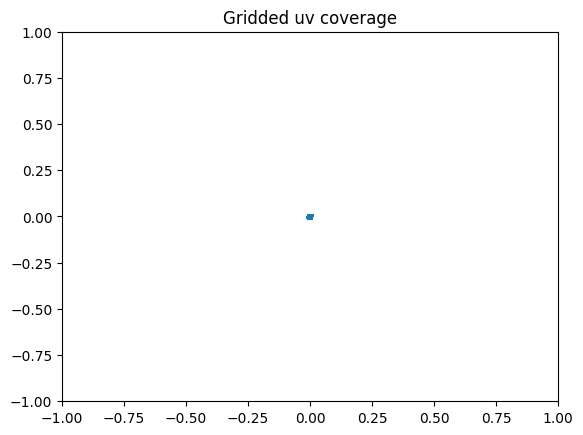

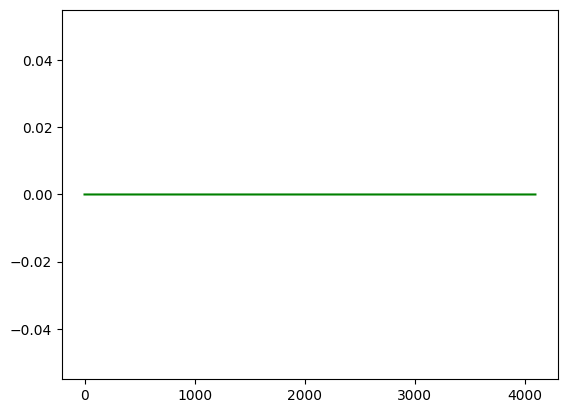

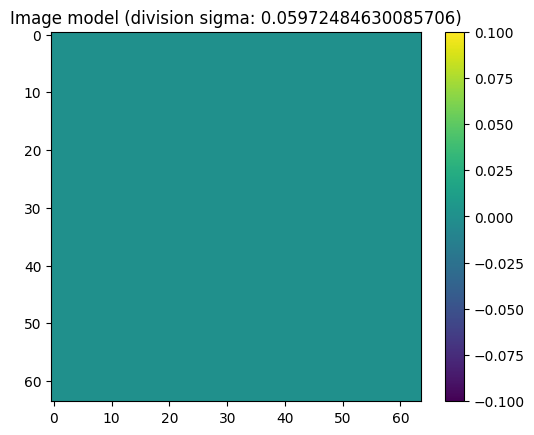

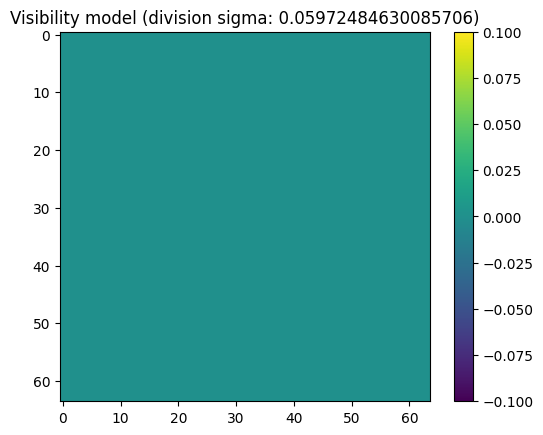

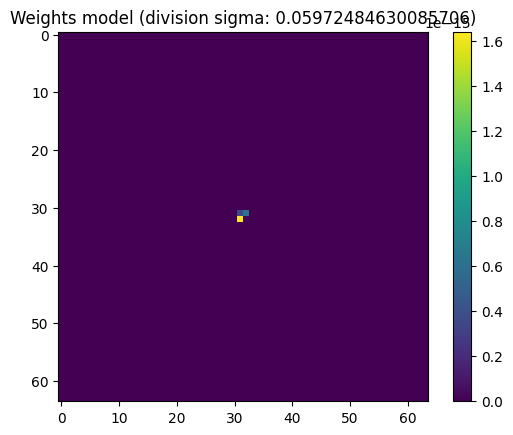

In [7]:
visibilidades_extrapoladas_dc_doar25, pesos_dc_doar25 = ejemplo_dc_doar25.data_processing()

In [5]:
print(visibilidades_extrapoladas_dc)

[[ 5.82871343e-06  8.37353557e-06  9.73375520e-06 ... -4.88806933e-06
  -1.24466260e-06  2.47786892e-06]
 [-2.04531230e-06  1.89811040e-06  5.61649931e-06 ... -1.00851297e-05
  -8.39974643e-06 -5.62744405e-06]
 [-9.04723138e-06 -5.80981801e-06 -1.64608647e-06 ... -9.73726689e-06
  -1.10452385e-05 -1.08550013e-05]
 ...
 [ 3.16961451e-06 -7.36808679e-07 -4.60738119e-06 ...  1.03321169e-05
   9.11104412e-06  6.60480599e-06]
 [ 9.23826741e-06  6.40757446e-06  2.61061549e-06 ...  9.11942238e-06
   1.06960219e-05  1.07343907e-05]
 [ 1.03761962e-05  1.01674205e-05  8.48671789e-06 ...  2.94620721e-06
   6.51799355e-06  9.10435530e-06]]


In [6]:
print(pesos_dc)

[[6.27948719e-20 6.74364723e-20 7.24185639e-20 ... 1.51318263e-19
  1.38753544e-19 1.27255478e-19]
 [6.86480122e-20 7.37670118e-20 7.92649381e-20 ... 1.63448017e-19
  1.49797232e-19 1.37312386e-19]
 [7.50566372e-20 8.07032277e-20 8.67716280e-20 ... 1.76572213e-19
  1.61739562e-19 1.48181532e-19]
 ...
 [1.44705673e-19 1.58431285e-19 1.73495253e-19 ... 1.56550336e-19
  1.44776660e-19 1.33888676e-19]
 [1.34538176e-19 1.47217237e-19 1.61124218e-19 ... 1.43113007e-19
  1.32439146e-19 1.22561468e-19]
 [1.25088933e-19 1.36801736e-19 1.49641196e-19 ... 1.30840096e-19
  1.21161951e-19 1.12199673e-19]]


## Ejemplo de optimización de parametros para datos grillados previamente:

In [ ]:
ejemplo_opti_gc = optimizacion_parametros_grillados.OptimizacionParametrosGrillados(
    "/home/stephan/polynomial_preprocessing/datasets/HD142/dirty_images_natural_251.fits",
    "/home/stephan/polynomial_preprocessing/datasets/HD142/hd142_b9cont_self_tav.ms", 
	[7, 21],
	[1e-3, 1e-1],
	2.5e-07, 
    129)

ejemplo_opti_gc.initialize_optimization(77)

In [ ]:
ejemplo_opti_gc = optimizacion_parametros_grillados.OptimizacionParametrosGrillados(
    "/home/stephan/polynomial_preprocessing/datasets/DoAr25/imagen_recortada.fits",
    "/home/stephan/polynomial_preprocessing/datasets/DoAr25/DoAr25_continuum.ms",
	[7, 20],
	[1e-4, 1e-1],
	-4e-08, 
    129)

ejemplo_opti_gc.initialize_optimization(77)

## Ejemplo de procesamiento de datos grillados:

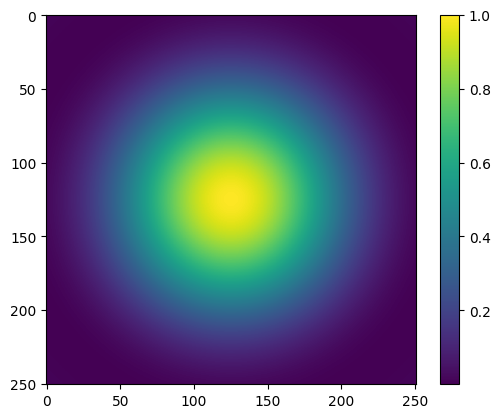

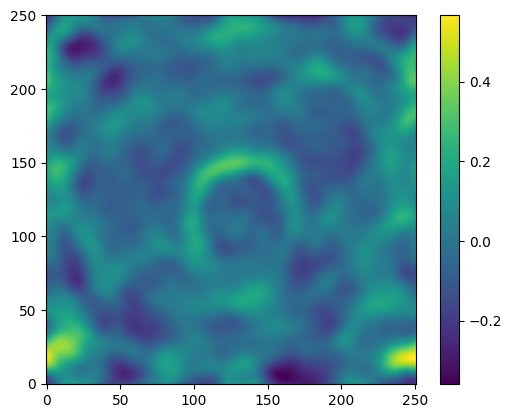

gw_sparse.shape:  (680,)
u_sparse:  (680,)
v_sparse:  (680,)
z_sparse.shape:  (680,)
9
New S: 8
Division: 0.023107219110480887
Sigma: 395202.98606790905


/home/stephan/anaconda3/envs/pyralysis-env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stephan/anaconda3/envs/pyralysis-env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Hice G-S
El tiempo de ejecución fue de:  0.3101520538330078


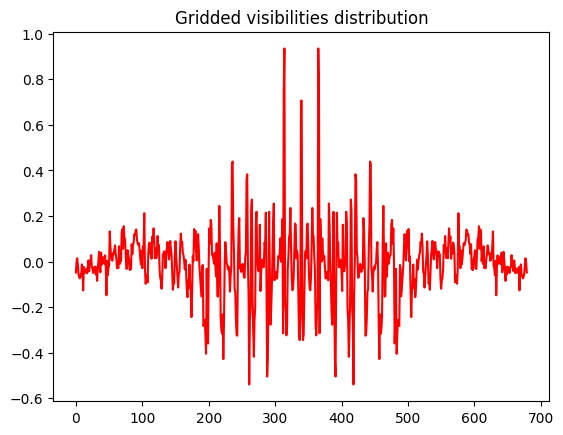

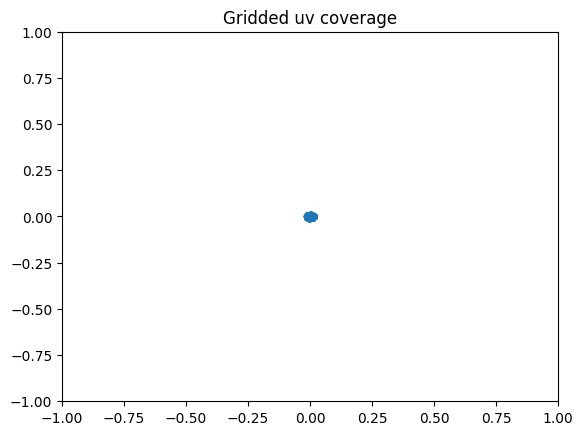

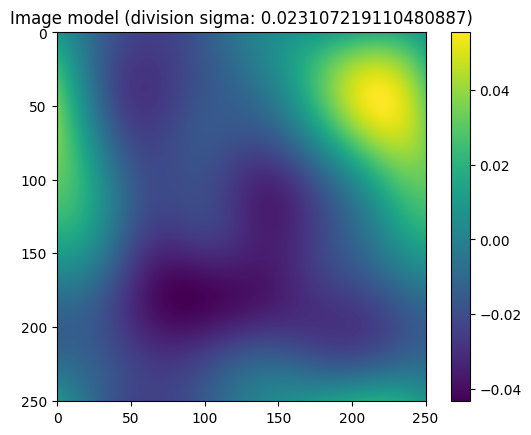

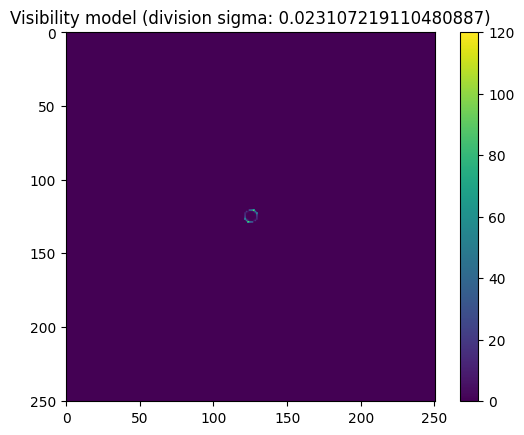

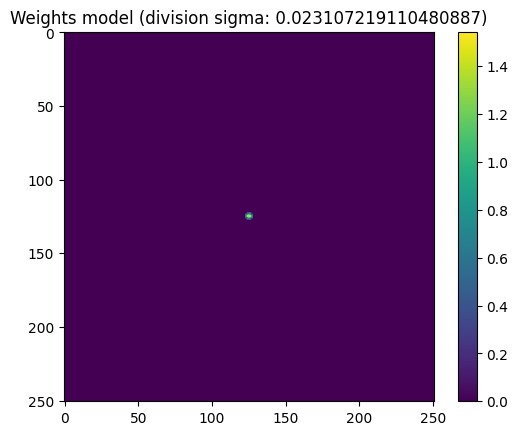

In [5]:
ejemplo_dg = procesamiento_datos_grillados.ProcesamientoDatosGrillados(
    "/home/stephan/polynomial_preprocessing/datasets/HD142/dirty_images_natural_251.fits",
    "/home/stephan/polynomial_preprocessing/datasets/HD142/hd142_b9cont_self_tav.ms", 
    8, 
    0.023107219110480887, 
    -2.5e-08, 
    251)

visibilidades_grilladas, pesos = ejemplo_dg.data_processing()

In [3]:
ejemplo_dg_2 = procesamiento_datos_grillados.ProcesamientoDatosGrillados(
    "/home/stephan/polynomial_preprocessing/datasets/DoAr25/imagen_recortada.fits",
    "/home/stephan/polynomial_preprocessing/datasets/DoAr25/DoAr25_continuum.ms", 
    10, 
    0.023107219110480887, 
    -4e-08, 
    2082)

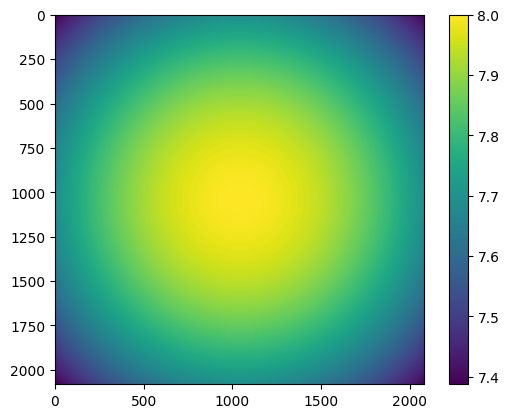

In [ ]:
visibilidades_grilladas_doar25, pesos_grillados_doar25 = ejemplo_dg_2.data_processing()